Blankenbach Benchmark Case 1
======

Steady isoviscous thermal convection
----

Two-dimensional, incompressible, bottom heated, steady isoviscous thermal convection in a 1 x 1 box, see case 1 of Blankenbach *et al.* 1989 for details.

![title](./images/blankenbach.png)

**This example introduces:**
1. Loading/Saving variables to disk.
2. Defining analysis tools.
3. Finding a steady state.

**Keywords:** Stokes system, advective diffusive systems, analysis tools

**References**

B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract


In [1]:
import underworld as uw
from underworld import function as fn
import underworld.visualisation as vis
import math
import numpy as np

Setup parameters
-----

In [2]:
boxHeight = 1.0
boxLength = 1.0
# Set grid resolution.
res = 128
# Set max & min temperautres
tempMin = 0.0
tempMax = 1.0

Choose which Rayleigh number, see case 1 of Blankenbach *et al.* 1989 for details.

In [3]:
case = "a" 
if(case=="a"):
    Ra=1.e4
    eta0=1.e23
elif(case=="b"):
    Ra=1.e5
    eta0=1.e22
else: 
    Ra=1.e6
    eta0=1.e21

Set input and output file directory 

In [4]:
inputPath  = 'input/1_03_BlankenbachBenchmark/'
outputPath = 'output/'
# Make output directory if necessary.
if uw.mpi.rank==0:
    import os
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

Create mesh and variables
------

In [5]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

velocityField       = mesh.add_variable(         nodeDofCount=2 )
pressureField       = mesh.subMesh.add_variable( nodeDofCount=1 )
temperatureField    = mesh.add_variable(         nodeDofCount=1 )
temperatureDotField = mesh.add_variable(         nodeDofCount=1 )

# initialise velocity, pressure and temperatureDot field
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureField.data[:]    = 0.
temperatureDotField.data[:] = 0.

Set up material parameters and functions
-----

Set values and functions for viscosity, density and buoyancy force.

In [6]:
# Set a constant viscosity.
viscosity = 1.

# Create our density function.
densityFn = Ra * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# A buoyancy function.
buoyancyFn = densityFn * z_hat

Set initial temperature field
-----
The initial temperature field can be loaded from a pre-run steady state data set ( ``LoadFromFile = True`` ) or set to a sinusodial perterbation ( ``LoadFromFile = False`` ).

In [7]:
# Steady state temperature field to be loaded from data file.
LoadFromFile = True

**If loading steady state data set**

Data is stored in h5 format from a 64\*64 grid resolution model.  Data has been saved for 3 different Rayleigh numbers, $Ra = 10^4$, $10^5$ or $10^6$. 

Once loaded the data will need to be re-meshed onto a new grid, unless the new resolution is also 64\*64.

For more information on using meshes see the user guide.


In [8]:
if(LoadFromFile == True):
    # Setup mesh and temperature field for 64*64 data file.
    mesh64 = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                       elementRes  = (64, 64), 
                                       minCoord    = (0., 0.), 
                                       maxCoord    = (boxLength, boxHeight),
                                       partitioned = False )
    temperatureField64  = mesh64.add_variable( nodeDofCount=1 ) 
    
    # read in saved steady state temperature field data
    if( case == "a" ):
        temperatureField64.load(inputPath+'tempfield_inp_64_Ra1e4.h5')
    elif( case == "b" ):
        temperatureField64.load(inputPath+'tempfield_inp_64_Ra1e5.h5')
    else:
        temperatureField64.load(inputPath+'tempfield_inp_64_Ra1e6.h5')
        
    if( res==64 ): # no remeshing needed, copy directly
        temperatureField.data[:] = temperatureField64.data[:]
    else: # remeshing needed
        temperatureField.data[:] = temperatureField64.evaluate(mesh)

**If using sinusodial perturbation**

In [9]:
if(LoadFromFile == False):
    temperatureField.data[:] = 0.
    pertStrength = 0.1
    deltaTemp = tempMax - tempMin
    for index, coord in enumerate(mesh.data):
        pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
        temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
        temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

**Show initial temperature field**



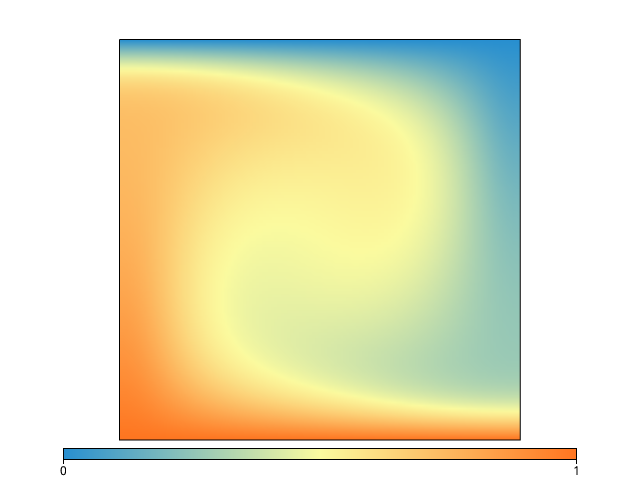

In [10]:
fig = vis.Figure()
fig.append( vis.objects.Surface(mesh, temperatureField) )
fig.show()

Create boundary conditions
----------

Set temperature boundary conditions on the bottom ( ``MinJ`` ) and top ( ``MaxJ`` ).

In [11]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the ``I`` (left and right side walls) and ``J`` (top and bottom walls) sets.

In [12]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

System setup
-----

**Setup a Stokes system**


In [13]:
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               fn_viscosity  = viscosity, 
                               fn_bodyforce  = buoyancyFn )
# get the default stokes equation solver
solver = uw.systems.Solver( stokes )

**Create an advection diffusion system**


In [14]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = [tempBC,] )

Analysis tools
-----

**Nusselt number**

The Nusselt number is the ratio between convective and conductive heat transfer

\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]





In [15]:
nuTop    = uw.utils.Integral( fn=temperatureField.fn_gradient[1], 
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

nuBottom = uw.utils.Integral( fn=temperatureField,               
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

In [16]:
nu = - nuTop.evaluate()[0]/nuBottom.evaluate()[0]
if uw.mpi.rank == 0 : print('Nusselt number = {0:.6f}'.format(nu))

Nusselt number = 4.856902


**RMS velocity**

The root mean squared velocity is defined by intergrating over the entire simulation domain via

\\[
\begin{aligned}
v_{rms}  =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]

where $V$ denotes the volume of the box.

In [17]:
intVdotV = uw.utils.Integral( fn.math.dot( velocityField, velocityField ), mesh )

vrms = math.sqrt( intVdotV.evaluate()[0] )
if uw.mpi.rank == 0 : print('Initial vrms = {0:.3f}'.format(vrms))

Initial vrms = 0.000


Main simulation loop
-----

If the initial conditions are loaded from file then this loop will only take a single step. If you would like to run the entire simulation from a small perturbation then change the ``LoadFromFile`` variable above to equal ``False``. Warning: the simulation will take a long time to get to steady state.

In [18]:
#initialise time, step, output arrays
time = 0.
step = 0
timeVal = []
vrmsVal = []

# starting from steady state == True
if(LoadFromFile == True):
    step_end = 1
else:
    step_end = 5000

# output frequency
step_output = max(1,min(100, step_end/10))
epsilon    = 1.e-8

velplotmax = 0.0
nuLast     = -1.0

In [19]:
# define an update function
def update():
    # Determining the maximum timestep for advancing the a-d system.
    dt = advDiff.get_max_dt()
    # Advect using this timestep size. 
    advDiff.integrate(dt)
    return time+dt, step+1

In [20]:
# Perform steps.
while step<=step_end:
    # Solving the Stokes system.
    solver.solve()
    
    # Calculate & store the RMS velocity and Nusselt number.
    vrms = math.sqrt( intVdotV.evaluate()[0] )
    nu   = - nuTop.evaluate()[0]/nuBottom.evaluate()[0]
    vrmsVal.append(vrms)
    timeVal.append(time)
    velplotmax = max(vrms, velplotmax)

    # print output statistics 
    if step%(step_end/step_output) == 0:
        if(uw.mpi.rank==0):
            print('steps = {0:6d}; time = {1:.3e}; v_rms = {2:.3f}; Nu = {3:.3f}; Rel change = {4:.3e}'
              .format(step, time, vrms, nu, abs((nu - nuLast)/nu)))
    # Check loop break conditions.
    if(abs((nu - nuLast)/nu) < epsilon):
        if(uw.mpi.rank==0):
            print('steps = {0:6d}; time = {1:.3e}; v_rms = {2:.3f}; Nu = {3:.3f}; Rel change = {4:.3e}'
              .format(step, time, vrms, nu, abs((nu - nuLast)/nu)))
        break
    nuLast = nu
    
    # update
    time, step = update()

steps =      0; time = 0.000e+00; v_rms = 42.869; Nu = 4.857; Rel change = 1.206e+00
steps =      1; time = 3.052e-05; v_rms = 42.869; Nu = 4.864; Rel change = 1.416e-03


Post analysis
-----

**Benchmark values**

The time loop above outputs $v_{rms}$ and $Nu$ as general statistics for the system. For comparison, the benchmark values for the RMS velocity and Nusselt number are shown below for different Rayleigh numbers. All benchmark values shown below were determined in Blankenbach *et al.* 1989 by extroplation of numerical results. 


| $Ra$          | $v_{rms}$   | $Nu$  |   $q_1$  | $q_2$  |
| ------------- |:-------------:|:-----:|:-----:|:-----:|
| 10$^4$ | 42.865 |  4.884 | 8.059 | 0.589 |
| 10$^5$ | 193.215 | 10.535 | 19.079 | 0.723 |
| 10$^6$ | 833.990 | 21.972 | 45.964 | 0.877 |


In [21]:
# Let's add a test to ensure things are working as expected
if case == "a":
    if not np.isclose(nu,4.884,rtol=1.e-2):
        raise RuntimeError("Model did not produce the expected Nusselt number.")
    if not np.isclose(vrms,42.865,rtol=1.e-2):
        raise RuntimeError("Model did not produce the expected Nusselt number.")

**Resulting pressure field**

Use the same method as above to plot the new temperature field. This can also be used to plot the pressure field, or any other data structures of interest.


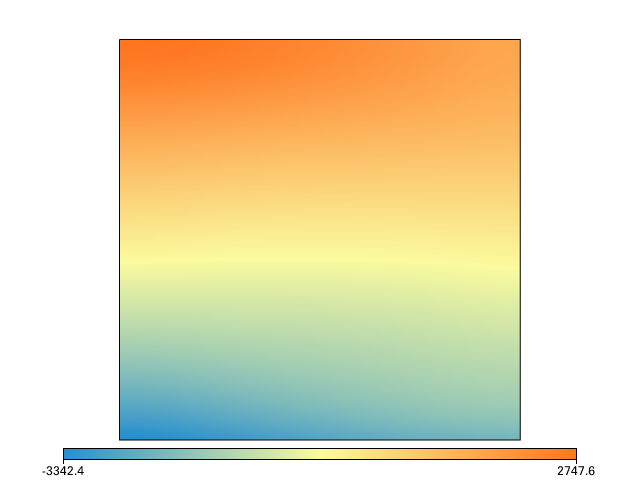

In [22]:
figtemp = vis.Figure()
figtemp.append( vis.objects.Surface( mesh, pressureField ) )
figtemp.show()

**Plot the velocity vector field**

For this example the velocity field is interesting to see. This is visualised in two ways, firstly plotting a surface colour map of the velocity magnitude, and secondly the velocity vectors at points on the mesh. For aesthetics the vector arrows are scaled by a little more than the maximum $v_{rms}$ value found in the time loop above.


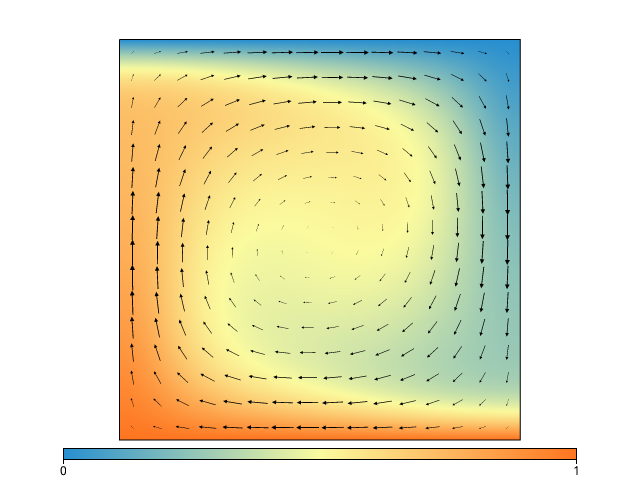

In [23]:
fig2 = vis.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig2.append( vis.objects.VectorArrows(mesh, velocityField/(2.5*velplotmax), arrowHead=0.2, scaling=0.1) )
fig2.append( vis.objects.Surface(mesh, temperatureField) )
fig2.show()

Analysis
----

The final benchmarks in the Blankenbach paper involve the temperature gradient in the vertical direction ($\frac{\partial T}{\partial z}$). This is easy to find using the underworld functions, as shown below.


In [24]:
tempgradField = temperatureField.fn_gradient
vertTGradField = - boxHeight * tempgradField[1] / tempMax # scaled for direct benchmarking below

**More benchmark values**


The vertical temperature gradient (above) is set up to be non-dimensional as per Blankenbach et al 1989. To compare to the benchmark values in their work the gradient is compared at the corners of the simulation box: $q_1$ at $x = 0$, $z = h$; $q_2$ at $x = l$, $z = h$; $q_3$ at $x = l$, $z = 0$; $q_4$ at $x = 0$, $z = 0$. Where $h$ = Box_Height and $l$ = Box_Length and the non-dimensional gradient field is given by
\\[
q = \frac{-h}{\Delta T} \left( \frac{\partial T}{\partial z} \right)
\\]

Provided the simulation is run to steady-state with sufficent resolution then the $q$ values should be close to the benchmark values given again below for different Rayleigh numbers.

| $Ra$          |    $q_1$  | $q_2$  |
| ------------- |:-----:|:-----:|
| 10$^4$ | 8.059 | 0.589 |
| 10$^5$ | 19.079 | 0.723 |
| 10$^6$ | 45.964 | 0.877 |


In [25]:
q1 = vertTGradField.evaluate_global( (       0., boxHeight) )
q2 = vertTGradField.evaluate_global( (boxLength, boxHeight) )
q3 = vertTGradField.evaluate_global( (boxLength,        0.) )
q4 = vertTGradField.evaluate_global( (       0.,        0.) )

if(uw.mpi.rank==0):
    print('Rayleigh number = {0:.1e}'.format(Ra))
    print('q1 = {0:.3f}; q2 = {1:.3f}'.format(q1[0][0], q2[0][0]))
    print('q3 = {0:.3f}; q4 = {1:.3f}'.format(q3[0][0], q4[0][0]))
    
    # Let's add a test to ensure things are working as expected
    if case == "a":
        if not np.isclose(q1[0][0],8.020,rtol=1.e-2):
            raise RuntimeError("Model did not produce the expected q1.")
        if not np.isclose(q2[0][0],0.589,rtol=1.e-2):
            raise RuntimeError("Model did not produce the expected q2.")

Rayleigh number = 1.0e+04
q1 = 8.021; q2 = 0.589
q3 = 8.021; q4 = 0.589


**Save time and rms values**

In [26]:
if(uw.mpi.rank==0):
    np.savetxt(outputPath+'vrms.txt', np.c_[timeVal, vrmsVal], header="Time, VRMS" )

**Calculate stress values for benchmark comparison**


Determine stress field for whole box in dimensionless units (King 2009)
\begin{equation}
\tau_{ij} = \eta \frac{1}{2} \left[ \frac{\partial v_j}{\partial x_i} + \frac{\partial v_i}{\partial x_j}\right]
\end{equation}
which for vertical normal stress becomes
\begin{equation}
\tau_{zz} = \eta \frac{1}{2} \left[ \frac{\partial v_z}{\partial z} + \frac{\partial v_z}{\partial z}\right] = \eta \frac{\partial v_z}{\partial z}
\end{equation}
which is implemented for the whole box in the functions defined below.

In [27]:
# get topography
stresstensorFn = 2.* stokes.fn_viscosity*fn.tensor.symmetric( velocityField.fn_gradient ) - (1.,1.,0.)*pressureField
verticalStressFn  = stresstensorFn[1]

# subtract the average value for benchmark
top_verts = mesh.specialSets["MaxJ_VertexSet"]
mean_sigma_zz_top = uw.utils.Integral(-verticalStressFn,
                                      mesh,
                                      'surface',
                                      top_verts).evaluate()/boxLength
sigma_zz_top = -verticalStressFn - mean_sigma_zz_top

Dimensionalise the stress from the vertical normal stress at the top of the box (King 2009)

$$
    \sigma_{t} = \frac{\eta_0 \kappa}{\rho g h^2}\tau _{zz} \left( x, z=h\right)
$$

where all constants have been defined above. Finally calculate the topography, defined using $h = \sigma_{top} / (\rho g)$.

In [28]:
# Set parameters in SI units
grav = 10        # m.s^-2
height = 1.e6    # m 
rho  = 4.0e3     # g.m^-3
kappa  = 1.0e-6  # m^2.s^-1

# dimensionalise 
dim_sigma_zz_top  = (eta0 * kappa / (height*height)) * sigma_zz_top

# find topography in [m]
topography        = dim_sigma_zz_top / (rho * grav) 

**Calculate x-coordinate at zero stress**

Calculate the zero point for the stress along the x-axis at the top of the box.

In [29]:
# First construct abs function
abs_topo = fn.math.abs(topography)
# Now create a `min_max` view function.
# These functions don't modify results, they simply observe
# calculated results as functions are being evaluated. 
# We will use this to watch out for the minimum value as 
# we traverse function evaluates.
# We also set `fn_auxiliary` which allows us to also capture
# the coordinate of the min value.
abs_topo_min_max = fn.view.min_max(abs_topo,fn_auxiliary=fn.coord())   # create min_max
ignore = abs_topo_min_max.evaluate(mesh.specialSets["MaxJ_VertexSet"]) # traverse function evaluations
min_abs_topo_coord = abs_topo_min_max.min_global_auxiliary()[0][0]     # get x coord of global min

**Topography comparison**

Topography of the top boundary calculated in the left and right corners as given in Table 9 of Blankenbach et al 1989.

| $Ra$          |    $\xi_1$  | $\xi_2$  |  $x$ ($\xi = 0$) |
| ------------- |:-----------:|:--------:|:--------------:|
| 10$^4$  | 2254.02   | -2903.23  | 0.539372          |
| 10$^5$  | 1460.99   | -2004.20  | 0.529330          |
| 10$^6$  | 931.96   | -1283.80  | 0.506490          |


In [30]:
e1 = topography.evaluate_global( (       0.,boxHeight) )
e2 = topography.evaluate_global( (boxLength,boxHeight) )

if(uw.mpi.rank==0):
    e1 = e1[0][0]  # pull values out of list of results
    e2 = e2[0][0]  # pull values out of list of results
    print('Rayleigh number = {0:.1e}'.format(Ra))
    print('Topography[x=0],[x=max] = {0:.2f}, {1:.2f}'.format(e1, e2))
    print('x(topo=0) = {0:.6f}'.format(min_abs_topo_coord))
    # output a summary file with benchmark values (useful for parallel runs)
    np.savetxt(outputPath+'summary.txt', [Ra, e1, e2, min_abs_topo_coord, q1, q2, q3, q4])

    # Let's add a test to ensure things are working as expected
    if case == "a":
        if not np.isclose(e1,2254.02,rtol=1.e-3):
            raise RuntimeError("Model did not produce the expected xi1.")
        if not np.isclose(e2,-2903.23,rtol=1.e-3):
            raise RuntimeError("Model did not produce the expected xi2.")
        if not np.isclose(min_abs_topo_coord,0.539372,rtol=1.e-3):
            raise RuntimeError("Model did not produce the expected xi2.")

Rayleigh number = 1.0e+04
Topography[x=0],[x=max] = 2252.36, -2900.67
x(topo=0) = 0.539062
